In [2]:
import numpy as np
import scipy.stats as sst
import matplotlib.pyplot as plt

### Useful functions

In [3]:
# Update normal-inverse-Wishart possibility function
def update_NIW(y_bar, S, n, mu, tau, Psi, nu):
    # y_bar    sample mean of the observations
    # S        n times the sample covariance of the observations
    # n        number of observations
    # mu       location parameter of the normal possibility function
    # tau      precision parameter of the normal possibility function
    # Psi      covaraince parameter in the inverse-Wishart possibility function
    # nu       number of degrees of freedom in the inverse-Wishart possibility function
    tmp = y_bar - mu
    Psi += S + tau * n / (tau + n) * np.outer(tmp, tmp)
    mu = (tau * mu + n * y_bar) / (tau + n)
    tau += n
    nu += n
    return mu, tau, Psi, nu

# Compute the consistency of observations with sample mean y_bar
def compute_consistency(y_bar, S, n, mu, tau, Psi, nu):
    # y_bar    sample mean of the observations
    # S        n times the sample covariance of the observations
    # n        number of observations
    # mu       location parameter of the normal possibility function
    # tau      precision parameter of the normal possibility function
    # Psi      covaraince parameter in the inverse-Wishart possibility function
    # nu       number of degrees of freedom in the inverse-Wishart possibility function
    
    # Compute non-discounted statistics
    tmp = y_bar - mu
    Psi_nd = Psi + S + tau * n / (tau + n) * np.outer(tmp, tmp)
    nu_nd = nu + n

    # Compute consistency
    c = n/2 * np.log(np.linalg.det(S / n))
    c += nu/2 * np.log(np.linalg.det(Psi / nu))
    c -= nu_nd/2 * np.log(np.linalg.det(Psi_nd / nu_nd))
    c /= d * (d + 3)/2
    return np.exp(c)

def estimate_NIW(method, y, index, outliers, T, Sigma, d, n, thrld_consistency=None, gen_y=False):
    # method   1: no outlier, 2: discount, 3: threshold and 4:standard
    # y        array of observations (unused if gen_y=True)
    # index    order in which observations should be assimilated
    # outliers  indices of the outliers in y
    # T        number of iterations
    # Sigma    true covariance matrix
    # d        dimension
    # n        number of observations
    # thrld_consistency  value of the threshold for method 3
    # gen_y    (bool) whether to generate observations or use y
    
    # initialisation
    mu = np.zeros(d)
    tau = 0
    Psi = np.zeros((d,d))
    nu = np.zeros(T)
    consistency = np.zeros(T)
    error = np.zeros(T)
    
    for t in range(T):
        # Observation index
        t_loc = index[t]
        
        if gen_y:
            # generate observation according to inliers/outliers
            if outliers[t_loc]:
                Sigma_loc = coeff_Sigma * Sigma
            else:
                Sigma_loc = Sigma
            y_loc = np.random.multivariate_normal(np.zeros(d), Sigma_loc, size=n).T
        else:
            # fetch current observation in y
            y_loc = y[:,:,t_loc]
        
        # Sufficient statistics
        y_bar = np.mean(y_loc, axis = 1)
        S = n * np.cov(y_loc)
        
        # Compute consistency
        c = 1
        if (t > 0) and (method > 1):
            c = compute_consistency(y_bar, S, n, mu, tau, Psi, nu[t-1])
        consistency[t] = c
        
        # Determine gamma based on method
        gamma = 1
        if method == 1:
            # No outlier
            if outliers[t_loc]:
                gamma = 0

        elif method == 2:
            # Discount
            gamma = c
        
        elif method == 3:
            # Threshold
            if c < thrld_consistency:
                gamma = c
        
        # Update
        (mu, tau, Psi, nu[t]) = update_NIW(y_bar, gamma*S, gamma*n, mu, tau, Psi, nu[t-1])
        
        # Compute error
        error[t] = np.linalg.norm(Sigma - Psi/nu[t], ord='fro')
        
    return error, consistency

### Parameters

In [4]:
# Dimension
d = 10

# Number of observations per iteration
n = 25

# Number of iterations
T = 500

# Probability of outlier
eps = 0.02

# Multiplicative coefficient for the covariance in outliers
coeff_Sigma = 3

# Consistency threshold
thrld_consistency = 0.25

## Repeats

### Sample outlier iterations

In [7]:
outliers = np.zeros(T, dtype=bool)
for t in range(T):
    if np.random.uniform() < eps:
        outliers[t] = True
t_outliers = np.where(outliers)[0]
print('Outliers at iterations:', t_outliers)

Outliers at iterations: [ 71  83 112 124 140 345 448 485]


### Run repeats

In [8]:
nof_repeats = 1000

error = np.zeros((4,T))
consistency = np.zeros((4,T))
index = np.linspace(0, T-1, T, dtype=int)

for i in range(nof_repeats):
    Sigma = sst.invwishart.rvs(df = d*np.sqrt(d), scale=np.eye(d))
    y = np.zeros((d, n, T))
    for t in range(T):
        if outliers[t]:
            Sigma_loc = coeff_Sigma * Sigma
        else:
            Sigma_loc = Sigma
        y[:,:,t] = np.random.multivariate_normal(np.zeros(d), Sigma_loc, size=n).T
    
    error_loc, cons_loc = estimate_NIW(1, y, index, outliers, T, Sigma, d ,n)
    consistency[0,] += cons_loc
    error[0,] += error_loc
    error_loc, cons_loc = estimate_NIW(2, y, index, outliers, T, Sigma, d, n)
    error[1,] += error_loc
    consistency[1,] += cons_loc
    error_loc, cons_loc = estimate_NIW(3, y, index, outliers, T, Sigma, d, n, thrld_consistency)
    error[2,] += error_loc
    consistency[2,] += cons_loc
    error_loc, cons_loc = estimate_NIW(4, y, index, outliers, T, Sigma, d, n)
    error[3,] += error_loc
    consistency[3,] += cons_loc

error /= nof_repeats
consistency /= nof_repeats

### Display results

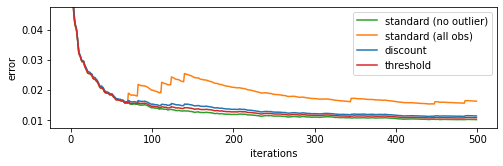

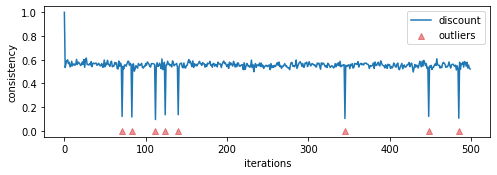

In [12]:
fig, ax = plt.subplots(figsize=(8, 2.4))
plt.plot(error[0,], c='C2', label='standard (no outlier)')
plt.plot(error[3,], c='C1', label='standard (all obs)')
plt.plot(error[1,], c='C0', label='discount')
plt.plot(error[2,], c='C3', label='threshold')
ax.set_ylim(0.0075, 0.0475)
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.gcf().subplots_adjust(bottom=0.18)

plt.savefig('Feature_error.pdf', format='pdf')

plt.figure(figsize=(8, 2.4))
plt.plot(consistency[1,], label='discount')
t_outliers = np.where(outliers)[0]
plt.scatter(t_outliers, np.zeros(t_outliers.size), marker='^', alpha=0.5, c='C3', label='outliers')
plt.xlabel('iterations')
plt.ylabel('consistency')
plt.legend();

## Single run

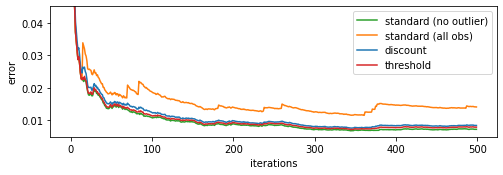

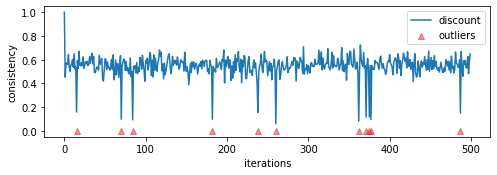

In [21]:
# Data generation

Sigma = sst.invwishart.rvs(df = d*np.sqrt(d), scale=np.eye(d))

y = np.zeros((d, n, T))
outliers = np.zeros(T, dtype=bool)
for t in range(T):
    if (t > 0) and (np.random.uniform() < eps):
        Sigma_loc = coeff_Sigma * Sigma
        outliers[t] = True
    else:
        Sigma_loc = Sigma
    
    y[:,:,t] = np.random.multivariate_normal(np.zeros(d), Sigma_loc, size=n).T

    
consistency = np.zeros((4,T))
error = np.zeros((4,T))
index = np.linspace(0, T-1, T, dtype=int)

error[0,], consistency[0,] = estimate_NIW(1, y, index, outliers, T, Sigma, d, n)
error[1,], consistency[1,] = estimate_NIW(2, y, index, outliers, T, Sigma, d, n)
error[2,], consistency[2,] = estimate_NIW(3, y, index, outliers, T, Sigma, d, n, thrld_consistency)
error[3,], consistency[3,] = estimate_NIW(4, y, index, outliers, T, Sigma, d, n)

plt.figure(figsize=(8, 2.4))
plt.plot(error[0,], c='C2', label='standard (no outlier)')
plt.plot(error[3,], c='C1', label='standard (all obs)')
plt.plot(error[1,], c='C0', label='discount')
plt.plot(error[2,], c='C3', label='threshold')
plt.ylim([0.005, 0.045])
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()

plt.figure(figsize=(8, 2.4))
plt.plot(consistency[1,], label='discount')
t_outliers = np.where(outliers)[0]
plt.scatter(t_outliers, np.zeros(t_outliers.size), marker='^', alpha=0.5, c='C3', label='outliers')
plt.xlabel('iterations')
plt.ylabel('consistency')
plt.legend();

## Multiple runs with random permutation of observations

In [26]:
# Estimation
nof_perm = 1000
error_final = np.zeros((3,nof_perm))

Sigma = sst.invwishart.rvs(df = d*np.sqrt(d), scale=np.eye(d))
y = np.zeros((d, n, T))
for t in range(T):
    if outliers[t]:
        Sigma_loc = coeff_Sigma * Sigma
    else:
        Sigma_loc = Sigma
    y[:,:,t] = np.random.multivariate_normal(np.zeros(d), Sigma_loc, size=n).T

for i_perm in range(nof_perm):
    
    # Random permutation
    cont = True
    while cont:
        index = np.random.permutation(T)
        cont = outliers[index[0]] #or outliers[index[1]]

    error = np.zeros((3,T))

    error[0,], _ = estimate_NIW(1, y, index, outliers, T, Sigma, d, n)
    error[1,], _ = estimate_NIW(2, y, index, outliers, T, Sigma, d, n)
    error[2,], _ = estimate_NIW(3, y, index, outliers, T, Sigma, d, n, thrld_consistency)
    
    error_final[:,i_perm] = error[:, -1]

mean_error = np.mean(error_final, axis=1)
excess_error = mean_error / mean_error[0] - 1
var_error = np.var(error_final, axis=1)

for i in range(1,3):
    print('method', i+1, '- excess error: +', excess_error[i], '%', ', variance:', var_error[i])

method 2 - excess error: + 0.20512994157804298 % , variance: 4.856309326296498e-08
method 3 - excess error: + 0.0945356503580208 % , variance: 3.96467903502215e-09


## Effect of dimension on consistency

### Computation

In [27]:
consistency = np.zeros((3,T))

d = 2
n = 5
Sigma= sst.invwishart.rvs(df = d*np.sqrt(d), scale=np.eye(d))
_, _, consistency[0,] = estimate_NIW(2, y, index, outliers, T, Sigma, d, gen_y=True, n=n)

print('Dimnesion', d, ', done')

d = 10
n = 25
Sigma = sst.invwishart.rvs(df = d*np.sqrt(d), scale=np.eye(d))
_, _, consistency[1,] = estimate_NIW(2, y, index, outliers, T, Sigma, d, gen_y=True, n=n)

print('Dimnesion', d, ', done')

d = 100
n = 250
Sigma = sst.invwishart.rvs(df = d*np.sqrt(d), scale=np.eye(d))
_, _, consistency[2,] = estimate_NIW(2, y, index, outliers, T, Sigma, d, gen_y=True, n=n)

print('Dimnesion', d, ', done')

done 2
done 10
done 100


### Display

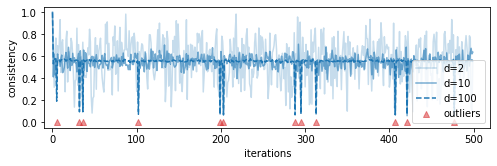

In [51]:
plt.figure(figsize=(8, 2.4))
plt.plot(consistency[0,], alpha=0.25, c='C0', label='d=2')
plt.plot(consistency[1,], alpha=0.6, c='C0', label='d=10')
plt.plot(consistency[2,], '--', alpha=1, c='C0', label='d=100')
t_outliers = np.where(outliers)[0]
plt.scatter(t_outliers, np.zeros(t_outliers.size), marker='^', alpha=0.5, c='C3', label='outliers')
plt.xlabel('iterations')
plt.ylabel('consistency')
plt.xlim([-10, 520])
plt.legend()
plt.gcf().subplots_adjust(bottom=0.18)

plt.savefig('Feature_dimension.pdf', format='pdf')